In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1)

In [2]:
DATA_PATH = "data/"
TRAIN_DATA_FILE = "exoTrainData.npy"
TRAIN_LABELS_FILE = "exoTrainLabels.npy"
TRAIN_DATA_UPSAMPLED_FILE = "exoTrainData_upsampled.npy"
TRAIN_LABELS_UPSAMPLED_FILE = "exoTrainLabels_upsampled.npy"
TEST_DATA_FILE = "exoTestData.npy"
TEST_LABELS_FILE = "exoTestLabels.npy"

x_train = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_FILE))
y_train = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_FILE))
x_train_upsampled = np.load("{}{}".format(DATA_PATH, TRAIN_DATA_UPSAMPLED_FILE))
y_train_upsampled = np.load("{}{}".format(DATA_PATH, TRAIN_LABELS_UPSAMPLED_FILE))
x_test = np.load("{}{}".format(DATA_PATH, TEST_DATA_FILE))
y_test = np.load("{}{}".format(DATA_PATH, TEST_LABELS_FILE))

# TODO: actually get this in some time units so can set autopower arg more legitimately
t = np.arange(x_train.shape[1])

print(x_train.shape)
print(y_train.shape)
print(x_train_upsampled.shape)
print(y_train_upsampled.shape)
print(x_test.shape)
print(y_test.shape)

(5087, 3197)
(5087,)
(10082, 3197)
(10082,)
(570, 3197)
(570,)


In [12]:
from sklearn import metrics

def compute_metrics(clf, x_train, y_train, x_test, y_test, model_name=""):
    print("Accuracy on training data:", clf.score(x_train, y_train))
    print("Accuracy on test data:", clf.score(x_test, y_test))
    test_predicted_probs = clf.predict_proba(x_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicted_probs)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    print("AUC:", metrics.auc(fpr, tpr))
    test_predicted = clf.predict(x_test)
    print("F1:", metrics.f1_score(y_test, test_predicted))
    print("Test prediction frequencies:")
    print(np.unique(test_predicted, return_counts=True))
    print("Confusion matrix:")
    cm = metrics.confusion_matrix(y_test, test_predicted)
    print(cm)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, square=True, xticklabels=["without-exo", "with-exo"], yticklabels=["without-exo", "with-exo"])
    plt.gca().set_yticks([0.1, 1.2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("{}_confusionmatrix.png".format(model_name), dpi=300, bbox_inches="tight")
    plt.show()
    sns.set(font_scale=1)

def compute_metrics_from_predictions(y_true, y_pred, y_pred_score=None, model_name=""):
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    if y_pred_score is not None:
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
        print("Threshold range:", thresholds.min(), thresholds.max())
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print("AUC:", metrics.auc(fpr, tpr))
    print("F1:", metrics.f1_score(y_true, y_pred))
    print("Test prediction frequencies:")
    print(np.unique(y_pred, return_counts=True))
    print("Confusion matrix:")
    cm = metrics.confusion_matrix(y_true, y_pred)
    print(cm)
    sns.set(font_scale=1.5)
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, square=True, xticklabels=["without-exo", "with-exo"], yticklabels=["without-exo", "with-exo"])
    plt.gca().set_yticks([0.1, 1.2])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("{}_confusionmatrix.png".format(model_name), dpi=300, bbox_inches="tight")
    plt.show()
    sns.set(font_scale=1)

# Box Least Squares SNR

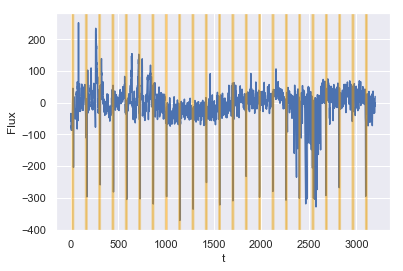

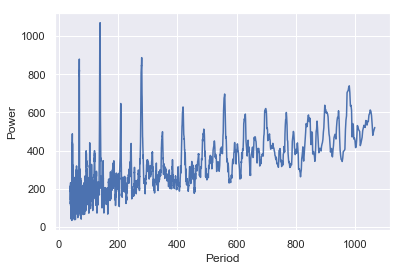

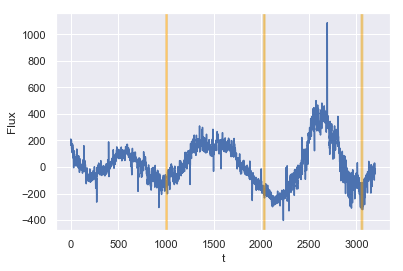

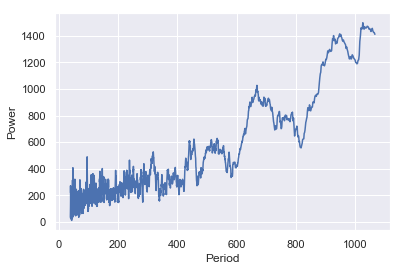

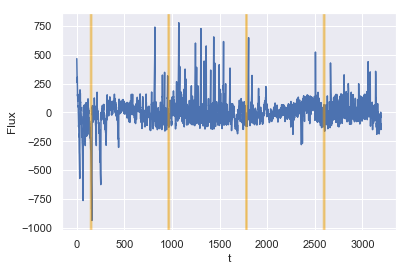

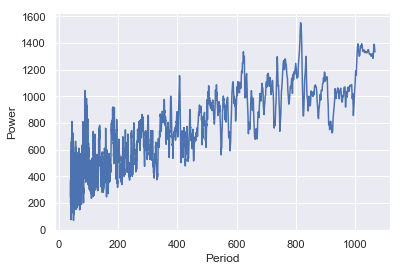

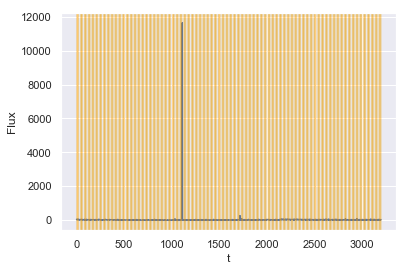

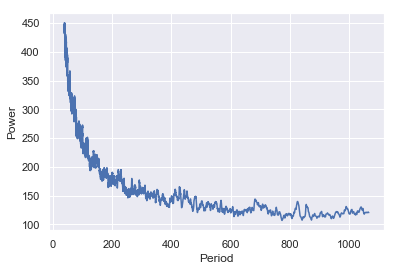

In [26]:
from astropy.stats import BoxLeastSquares

for i in [1, 5, 70, 71]:
    bls = BoxLeastSquares(t, x_train[i])
    periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
    max_power = np.argmax(periodogram.power)
    mask = bls.transit_mask(t,
                            periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
    
    plt.plot(t, x_train[i])
    plt.xlabel("t")
    plt.ylabel("Flux")
    for ti in np.nonzero(mask)[0]:
        plt.axvline(ti, color="orange", alpha=0.06)
    plt.savefig("flux{}.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()
    
    plt.plot(periodogram.period, periodogram.power)
    plt.xlabel("Period")
    plt.ylabel("Power")
    plt.savefig("periodogram{}.png".format(i), dpi=300, bbox_inches="tight")
    plt.show()

In [21]:
from astropy.stats import BoxLeastSquares

def get_bls_snr(x):
    snrs = []
    for i in range(x.shape[0]):
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        # based on https://arxiv.org/pdf/astro-ph/0206099.pdf
        snrs.append(periodogram.depth_snr[max_power])
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(snrs).reshape((-1, 1))

In [22]:
%%time

bls_snr_train = get_bls_snr(x_train)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
........
Wall time: 21min 44s


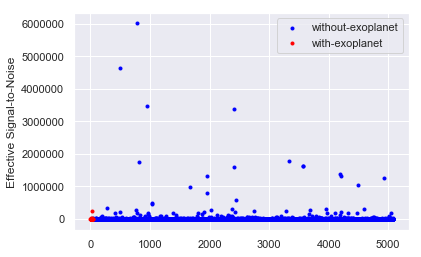

12.244975193456341
6029538.61968672


In [23]:
plt.scatter(np.arange(bls_snr_train.shape[0])[y_train==0], bls_snr_train.flatten()[y_train==0], marker='.', color="blue", label="without-exoplanet")
plt.scatter(np.arange(bls_snr_train.shape[0])[y_train==1], bls_snr_train.flatten()[y_train==1], marker='.', color="red", label="with-exoplanet")
plt.ylabel("Effective Signal-to-Noise")
plt.legend()
plt.savefig("bls_snr.png", dpi=300, bbox_inches="tight")
plt.show()
print(bls_snr_train.min())
print(bls_snr_train.max())

In [24]:
print(bls_snr_train[1], bls_snr_train[70])

[1069.2199266] [1550.77534472]


Accuracy: 0.35521918616080206
Threshold range: 12.244975193456341 6029539.61968672


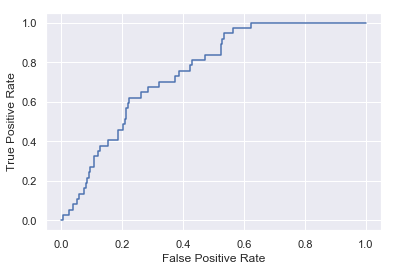

AUC: 0.7537489965212738
F1: 0.022063208109719738
Test prediction frequencies:
(array([False,  True]), array([1770, 3317], dtype=int64))
Confusion matrix:
[[1770 3280]
 [   0   37]]


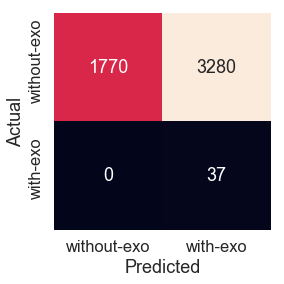

In [25]:
bls_snr_train_pred = bls_snr_train > 2e2
compute_metrics_from_predictions(y_train, bls_snr_train_pred, bls_snr_train, "blssnr_train")

In [7]:
bls_snr_test = get_bls_snr(x_test)

..................................................
.......


Accuracy: 0.4368421052631579
Threshold range: 28.52762284759409 1291829.953700316


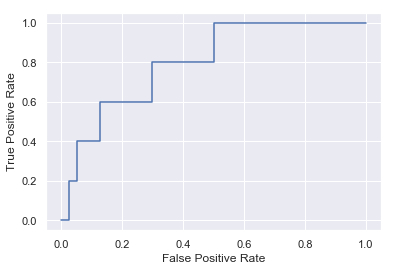

AUC: 0.7989380530973451
F1: 0.030211480362537766
Test prediction frequencies:
(array([False,  True]), array([244, 326], dtype=int64))
Confusion matrix:
[[244 321]
 [  0   5]]


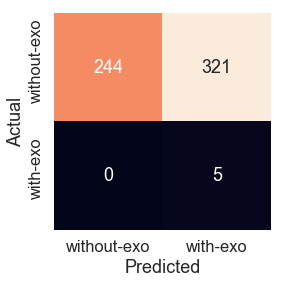

In [13]:
bls_snr_test_pred = bls_snr_test > 2e2
compute_metrics_from_predictions(y_test, bls_snr_test_pred, bls_snr_test, "blssnr_test")

# BLS with Logit

In [8]:
from astropy.stats import BoxLeastSquares

stat_names = ["depth", "depth_odd", "depth_even", "depth_half", "depth_phased"]

def get_bls_features(x):
    features = []
    for i in range(x.shape[0]):
        # adapted from http://docs.astropy.org/en/stable/stats/bls.html#peak-statistics
        bls = BoxLeastSquares(t, x[i])
        periodogram = bls.autopower(20, minimum_n_transit=4, objective="snr")  # arg is the granularity of considered durations
        max_power = np.argmax(periodogram.power)
        stats = bls.compute_stats(periodogram.period[max_power],
                                  periodogram.duration[max_power],
                                  periodogram.transit_time[max_power])
        features.append([stats[s][0] / stats[s][1] for s in stat_names])
        features[-1].extend([stats[s][0] for s in stat_names])
        features[-1].extend([stats[s][1] for s in stat_names])
        features[-1].append(periodogram.power[max_power])
        features[-1].append(periodogram.period[max_power])
        features[-1].append(periodogram.duration[max_power])
        features[-1].append(periodogram.transit_time[max_power])
        features[-1].append(periodogram.depth_snr[max_power])
        if (i + 1) % 10 == 0:
            print(".", end="")
        if (i + 1) % 500 == 0:
            print()
    print()
    return np.array(features)

In [9]:
%%time

bls_train_features = get_bls_features(x_train_upsampled)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
...............................

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
bls_train_features = scaler.fit_transform(bls_train_features)

In [11]:
from sklearn.linear_model import LogisticRegression

bls_logit = LogisticRegression()
bls_logit.fit(bls_train_features, y_train_upsampled)

C:\Users\czhao\Miniconda3\envs\ml\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [12]:
print(bls_logit.coef_)
# print(bls_train_ratios.min(), bls_train_ratios.max())
# print("Ratio decision boundary:", -bls_logit.intercept_ / bls_logit.coef_)

# TODO: plot data with decision boundary

[[-0.8711434   2.53327445 -3.66301826  0.57520778  0.59874269  0.61858991
  -2.82990633  3.50267179 -0.18846693 -0.73475727  0.73426301  1.47740492
  -0.77875882 -5.36501615  1.22088686 -1.32655319  2.39335077  0.
  -0.29159704  1.04088642]]


In [13]:
bls_test_features = get_bls_features(x_test)

..................................................
.......


In [14]:
bls_test_features = scaler.transform(bls_test_features)

In [17]:
bls_logit.predict_proba(bls_test_features[:10])

array([[0.518571  , 0.481429  ],
       [0.73792551, 0.26207449],
       [0.55604465, 0.44395535],
       [0.36684466, 0.63315534],
       [0.38338437, 0.61661563],
       [0.71739234, 0.28260766],
       [0.34602935, 0.65397065],
       [0.29055482, 0.70944518],
       [0.69364304, 0.30635696],
       [0.80388409, 0.19611591]])

In [15]:
np.save("bls_train.npy", bls_train_features)
np.save("bls_test.npy", bls_test_features)

Accuracy on training data: 0.6219996032533227
Accuracy on test data: 0.5666666666666667


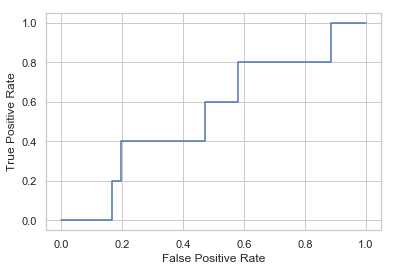

AUC: 0.5401769911504425
F1: 0.015936254980079684
Test prediction frequencies:
(array([0., 1.]), array([324, 246], dtype=int64))
Confusion matrix:
[[321 244]
 [  3   2]]


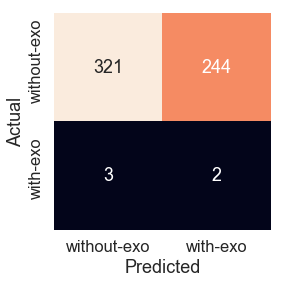

In [16]:
compute_metrics(bls_logit, bls_train_features, y_train_upsampled, bls_test_features, y_test, "blslogit_train")

# LSTM

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, CuDNNLSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential([
#     LSTM(16, input_shape=(x_train.shape[1], 1), dropout=0.2, recurrent_dropout=0.2),
#     Bidirectional(CuDNNLSTM(16, return_sequences=True)),
    Bidirectional(CuDNNLSTM(4)),
    Dense(4),
    Dropout(0.5),
    Dense(1),
    Activation("sigmoid"),
])
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.FalseNegatives()])
x_train_lstm = x_train_upsampled[:, :, np.newaxis]
y_train_lstm = y_train_upsampled
x_test_lstm = x_test[:, :, np.newaxis]
y_test_lstm = y_test
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [43]:
%%time

N_EPOCHS = 5
BATCH_SIZE = 32

hist = model.fit(x_train_lstm, y_train_lstm, validation_data=(x_test_lstm, y_test_lstm), epochs=N_EPOCHS, batch_size=BATCH_SIZE)
train_losses.extend(hist.history["loss"])
test_losses.extend(hist.history["val_loss"])
train_accuracies.extend(hist.history["acc"])
test_accuracies.extend(hist.history["val_acc"])

Train on 10082 samples, validate on 570 samples
Epoch 1/5
10082/10082 [==============================] - 83s 8ms/sample - loss: 0.4140 - acc: 0.8143 - false_negatives_10: 476.0000 - val_loss: 0.3945 - val_acc: 0.7982 - val_false_negatives_10: 2.0000
Epoch 2/5
10082/10082 [==============================] - 82s 8ms/sample - loss: 0.4020 - acc: 0.8243 - false_negatives_10: 419.0000 - val_loss: 0.4066 - val_acc: 0.7860 - val_false_negatives_10: 1.0000
Epoch 3/5
10082/10082 [==============================] - 82s 8ms/sample - loss: 0.3806 - acc: 0.8373 - false_negatives_10: 328.0000 - val_loss: 0.3854 - val_acc: 0.7965 - val_false_negatives_10: 1.0000
Epoch 4/5
10082/10082 [==============================] - 83s 8ms/sample - loss: 0.3702 - acc: 0.8454 - false_negatives_10: 268.0000 - val_loss: 0.4163 - val_acc: 0.7825 - val_false_negatives_10: 1.0000
Epoch 5/5
10082/10082 [==============================] - 1289s 128ms/sample - loss: 0.3568 - acc: 0.8538 - false_negatives_10: 260.0000 - val_lo

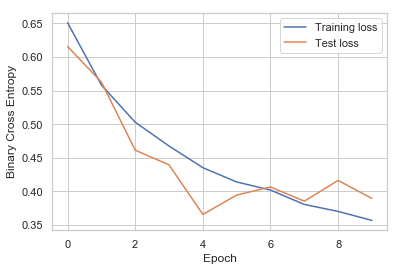

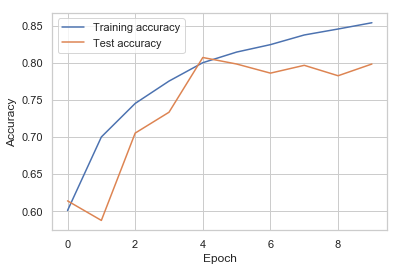

In [48]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy")
plt.legend()
plt.savefig("lstm_loss.png", dpi=300, bbox_inches="tight")
plt.show()

plt.plot(train_accuracies, label="Training accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("lstm_accuracy.png", dpi=300, bbox_inches="tight")
plt.show()

In [45]:
lstm_test_out = model.predict(x_test_lstm)

Accuracy: 0.7982456140350878
Threshold range: 2.9802322e-08 1.9807093


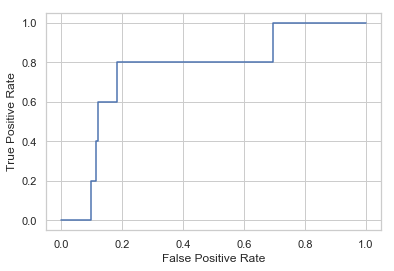

AUC: 0.7585840707964602
F1: 0.06504065040650407
Test prediction frequencies:
(array([False,  True]), array([452, 118], dtype=int64))
Confusion matrix:
[[451 114]
 [  1   4]]


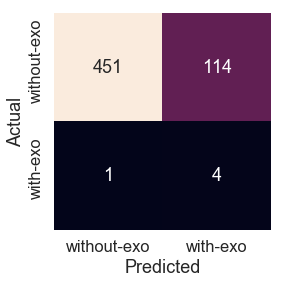

In [49]:
lstm_test_pred = lstm_test_out > 0.5
compute_metrics_from_predictions(y_test, lstm_test_pred, lstm_test_out, "lstm_test")